In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
%%writefile content.json
{"intents":
   [
      {
         "tag": "greeting",
         "input": ["Hi", "Hey", "Is anyone there?", "Hello", "Hay"],
         "responses": ["Hello", "Hi","How are you"
         ]
      },
      {
          "tag": "whoami",
          "input": ["Who are you?", "What are you?", "Is anyone there?", "Hello", "Hay", "Who am I speaking with?", "What's your name?", "Who is this?"],
          "responses": ["Hello! I'm Shalini, a chatbot designed to assist you in your studies.", "Hi! I'm Shalini, here to help with your academic questions.", "Hey there! I'm Shalini, your study assistant chatbot."]
      },
      {
          "tag": "creator",
          "input": ["Who created you?", "Who made you?", "Who developed you?", "Who built this bot?", "Who programmed you?"],
          "responses": ["I was created by Haridev, Anna, and Sabari."]
      },
      {
          "tag": "whoami",
          "input": ["Who are you?", "What are you?", "Is anyone there?", "Hello", "Hay", "Who am I speaking with?", "What's your name?", "Who is this?", "What is your purpose?", "Are you a real person?", "Are you human?"],
          "responses": ["Hello! I'm Shalini, a chatbot designed to assist you in your studies.", "Hi! I'm Shalini, here to help with your academic questions.", "Hey there! I'm Shalini, your study assistant chatbot.", "I'm Shalini, an AI created to help with study and academic tasks.", "I’m Shalini, your virtual assistant for studying."]
      },
      {
          "tag": "creator",
          "input": ["Who created you?", "Who made you?", "Who developed you?", "Who built this bot?", "Who programmed you?", "Who are your creators?", "Who designed you?", "Who is behind this bot?", "Who made this assistant?"],
          "responses": ["I was created by Haridev, Anna, and Sabari.", "My creators are Haridev, Anna, and Sabari.", "I was built by Haridev, Anna, and Sabari to assist with studies.", "The team of Haridev, Anna, and Sabari created me.", "Haridev, Anna, and Sabari are the minds behind this bot."]
      },
      {
          "tag": "purpose",
          "input": ["What can you do?", "How can you help me?", "What's your purpose?", "What is your function?", "How are you useful?", "What are you here for?", "Why do you exist?", "What is your role?", "How can you assist?", "What are you here to do?"],
          "responses": ["I’m here to assist you with your studies by answering questions and providing helpful information.", "My purpose is to support you in your academic journey.", "I can help with study-related questions and provide guidance for your academic needs.", "I'm here to make studying a bit easier by providing information and help.", "My goal is to assist you with academic queries and tasks."]
      },
      {
          "tag": "study_help",
          "input": ["Can you help me with my homework?", "Can you answer study questions?", "Are you good for learning?", "What study help can you provide?", "Can you explain things?", "Are you good with school work?", "Can you solve problems?", "Can you assist with assignments?", "Can you help with projects?", "Can you provide learning resources?"],
          "responses": ["Yes, I can help with study questions and provide explanations.", "I’m here to assist with homework, assignments, and study resources.", "I can answer academic questions and explain study topics.", "I’m ready to help with any study-related questions you have.", "Yes, I can assist with learning and understanding various topics."]
      }


   ]
}

Writing content.json


In [4]:
with open('content.json') as content:
   data1 = json.load(content)

In [5]:
tags = []
inputs = []
responses = {}
for intent in data1['intents']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [6]:
data = pd.DataFrame({'inputs': inputs, 'tags': tags})

In [7]:
data

,inputs,tags
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Hay,greeting
5,Who are you?,whoami
6,What are you?,whoami
7,Is anyone there?,whoami
8,Hello,whoami
9,Hay,whoami


In [8]:
data = data.sample(frac=1)

In [9]:
import string
data['inputs'] = data['inputs'].apply(lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
18,who are you,whoami
5,who are you,whoami
43,what are you here for,purpose
39,how can you help me,purpose
6,what are you,whoami
16,who built this bot,creator
2,is anyone there,greeting
47,what are you here to do,purpose
46,how can you assist,purpose
48,can you help me with my homework,study_help


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)
#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])


In [11]:
input_shape = x_train.shape[1]
print(input_shape)

7


In [12]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)
output_length = le.classes_.shape[0]
print("output length : ", output_length)

number of unique words :  65
output length :  5


In [13]:
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 10)(i)
x = LSTM(10, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model = Model(i, x)

In [14]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [15]:
train=model.fit(x_train, y_train, epochs=200)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1796 - loss: 1.6086
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2787 - loss: 1.6030 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3976 - loss: 1.5973 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3768 - loss: 1.5939
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3768 - loss: 1.5887 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3455 - loss: 1.5845 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3976 - loss: 1.5732 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3341 - loss: 1.5758 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3226 - loss: 1.5658 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3121 - loss: 1.5601 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3434 - loss: 1.5514 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3330 - los

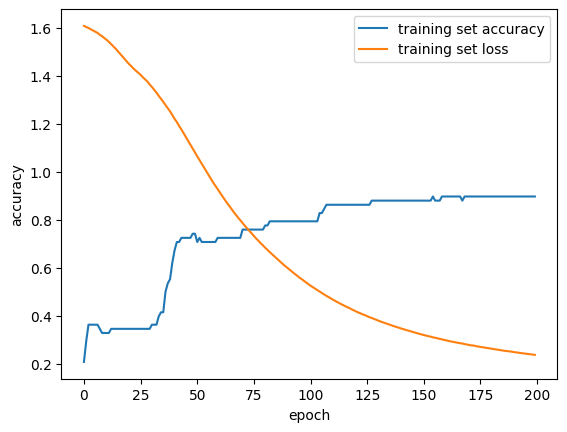

In [16]:
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='training set loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()


In [17]:
import random

while True:
  texts_p = []
  prediction_input = input('You: ')

  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input], input_shape)

  output = model.predict(prediction_input)
  output = output.argmax()

  response_tag = le.inverse_transform([output])[0]
  print("Shalini: ", random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You: Hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Shalini:  I'm Shalini, an AI created to help with study and academic tasks.
You: Who are you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Shalini:  Hello! I'm Shalini, a chatbot designed to assist you in your studies.
You: What can you do
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Shalini:  My purpose is to support you in your academic journey.
You: are you good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Shalini:  Hey there! I'm Shalini, your study assistant chatbot.
You: how can you help me
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Shalini:  I'm here to make studying a bit easier by providing information and help.
You: provide information
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Shalini:  I’m Shalini, your virtual assistant for studying.
You: who built you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Shalini:  I was built by Haridev, Anna, and Sabari to assist with studies.
You: can you provide learning resources
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Shalini:  Yes, I c

KeyboardInterrupt: Interrupted by user

In [18]:
 model.save('chatbot_model.h5')

In [21]:
tf.keras.models.save_model(model, 'my_model.keras')

In [23]:
from google.colab import files
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>